<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/omni_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: Generate GPT text embeddings from OpenAI for texts

Wikipedia Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

In [ ]:
%pip install llama-index-vector-stores-qdrant

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "BTS",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

## Parse Wikipedia Images and texts. Load into local folder

In [ ]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "San Francisco",
    "Batman",
    "Vincent van Gogh",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core.embeddings.omni_modal_base import Modalities
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.indices.omni_modal import OmniModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index_v1 = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)
index = OmniModalVectorStoreIndex.from_multi_modal(index_v1)

/Users/haotianzhang/llama_index/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plot downloaded Images from Wikipedia

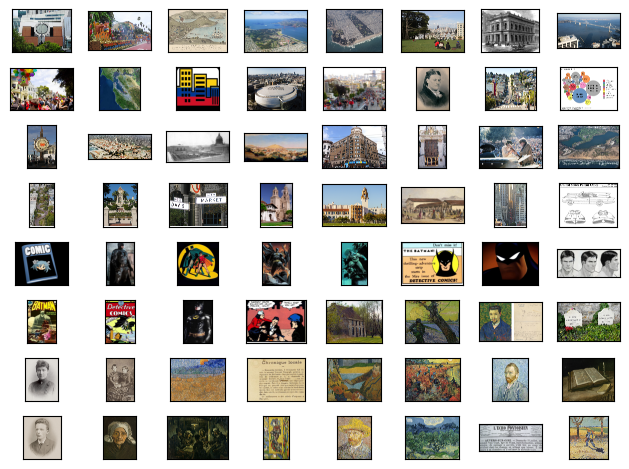

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Get Multi-Modal retrieval results for some example queries

In [ ]:
test_query = "who are BTS team members"
# generate  retrieval results
retriever = index.as_retriever(
    similarity_top_k={Modalities.TEXT.key: 3, Modalities.IMAGE.key: 5}
)
retrieval_results = retriever.retrieve(test_query)

**Node ID:** e30e1817-4e31-4047-be5d-37502560920c<br>**Similarity:** 0.808149809808292<br>**Text:** BTS (Korean: 방탄소년단; RR: Bangtan Sonyeondan; lit. Bulletproof Boy Scouts), also known as the Bangtan Boys, is a South Korean boy band formed in 2010. The band consists of Jin, Suga, J-Hope, RM, Jimi...<br>

**Node ID:** 024f3296-37c8-46d5-a184-2f78c621a99f<br>**Similarity:** 0.7987048642063129<br>**Text:** === Fandom ===
According to Kyung Hyun Kim, BTS's rise was facilitated by a great increase in music video programming and consumption on YouTube and the coming of an idol empire, including merchand...<br>

**Node ID:** c564ccf4-a94f-408f-8b21-224538dc2e94<br>**Similarity:** 0.7838098925118134<br>**Text:** == History ==


=== 2010–2014: Formation and early years ===
BTS was formed in 2010, after Big Hit Entertainment CEO Bang Si-hyuk wanted to form a hip hop group around RM (Kim Nam-joon), an undergr...<br>

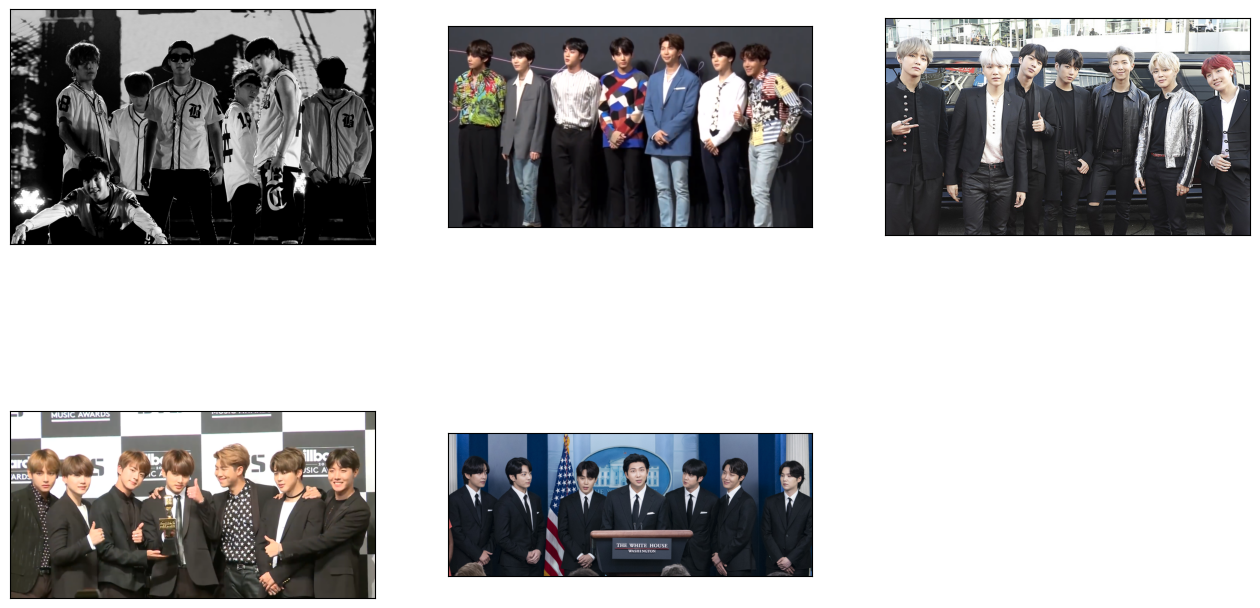

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** e002927c-0bf5-482b-a0a1-0ee2f3cd48f9<br>**Similarity:** 0.8675476190545354<br>**Text:** Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪləɱ vɑŋ ˈɣɔx] ; 30 March 1853 – 29 July 1890) was a Dutch Post-Impressionist painter who is among the most famous and influential figures in the history...<br>

**Node ID:** 69ef1c64-a5b4-468c-a58c-7d36151961a7<br>**Similarity:** 0.8661792475490765<br>**Text:** ==== Flowers ====

Van Gogh painted several landscapes with flowers, including roses, lilacs, irises, and sunflowers. Some reflect his interests in the language of colour, and also in Japanese ukiy...<br>

**Node ID:** f971a611-a8b9-48b4-a81b-d3856438aab8<br>**Similarity:** 0.8616832203971132<br>**Text:** ==== Portraits ====

Van Gogh said portaiture was his greatest interest. "What I'm most passionate about, much much more than all the rest in my profession", he wrote in 1890, "is the portrait, the...<br>

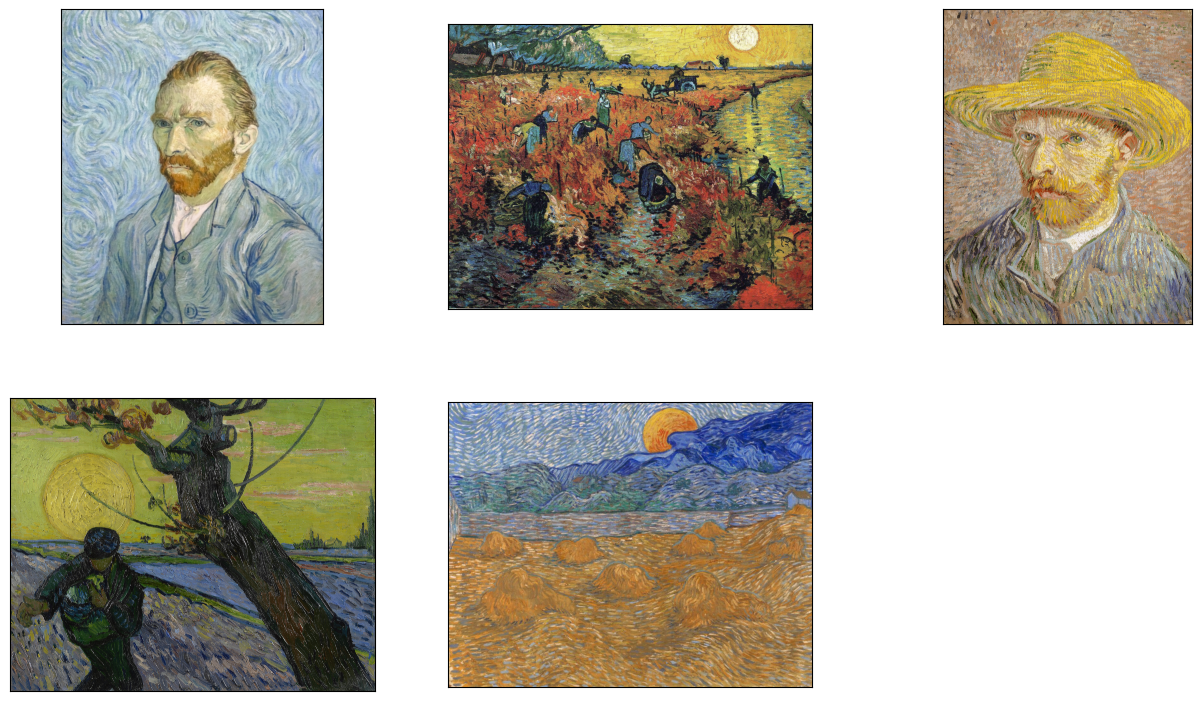

In [ ]:
test_query = "what are Vincent van Gogh's famous paintings"
# generate  retrieval results
retriever = index.as_retriever(
    similarity_top_k={Modalities.TEXT.key: 3, Modalities.IMAGE.key: 5}
)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 8c14be3e-345a-4764-9b64-dacff771bc04<br>**Similarity:** 0.8689195893277072<br>**Text:** === Tourism and conventions ===

Tourism is one of San Francisco's most important private-sector industries, accounting for more than one out of seven jobs in the city. The city's frequent portraya...<br>

**Node ID:** 22aa7d86-017f-433d-98dc-4007d9f67c17<br>**Similarity:** 0.8452524742723133<br>**Text:** === LGBT ===

San Francisco has long had an LGBT-friendly history. It was home to the first lesbian-rights organization in the United States, Daughters of Bilitis; the first openly gay person to ru...<br>

**Node ID:** 3846a17a-79d8-415e-9bcf-76c818b27203<br>**Similarity:** 0.8329496262980858<br>**Text:** == Parks and recreation ==

Several of San Francisco's parks and nearly all of its beaches form part of the regional Golden Gate National Recreation Area, one of the most visited units of the Natio...<br>

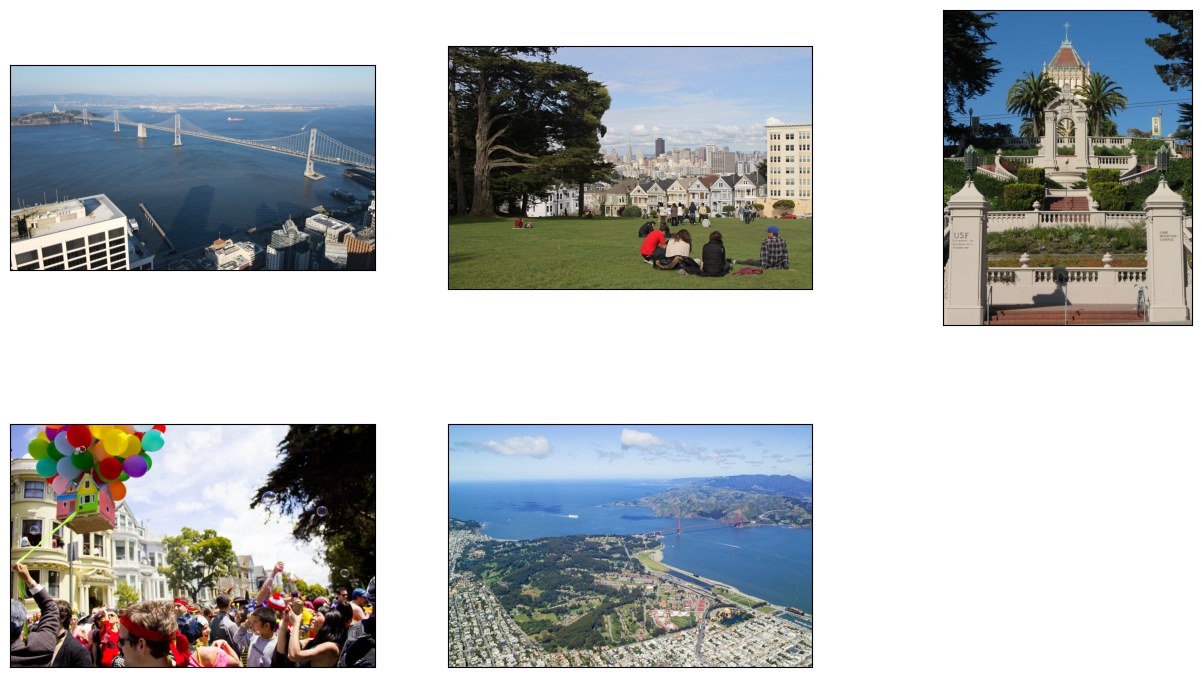

In [ ]:
test_query = "what is the popular tourist attraction in San Francisco"
# generate  retrieval results
retriever = index.as_retriever(
    similarity_top_k={Modalities.TEXT.key: 3, Modalities.IMAGE.key: 5}
)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 214c61be-dad6-403c-b301-bc2320b87e7a<br>**Similarity:** 0.7808396168295813<br>**Text:** The Tesla Model S is a battery electric full-size luxury sedan with a liftback body style built by Tesla, Inc. since 2012. The Model S features a battery-powered dual-motor, all-wheel drive layout,...<br>

**Node ID:** 15b737b4-90e3-443a-87aa-13a7d7e80b87<br>**Similarity:** 0.7807424063856144<br>**Text:** === P100D ===
The P100D outputs 439 kW (589 hp) and 1,248 N⋅m (920 lbf⋅ft) torque on a dynamometer.As of March 2017, P100D was the world's quickest production vehicle with a NHRA rolling start to 6...<br>

**Node ID:** e134452b-3031-47b0-a20c-df4fe32f1bcf<br>**Similarity:** 0.7754107325086438<br>**Text:** === Recalls ===
As of December 2021, Tesla had had seven Model S recalls:
On June 14, 2013, Tesla recalled Model S vehicles manufactured between May 10, 2013, and June 8, 2013, due to improper meth...<br>

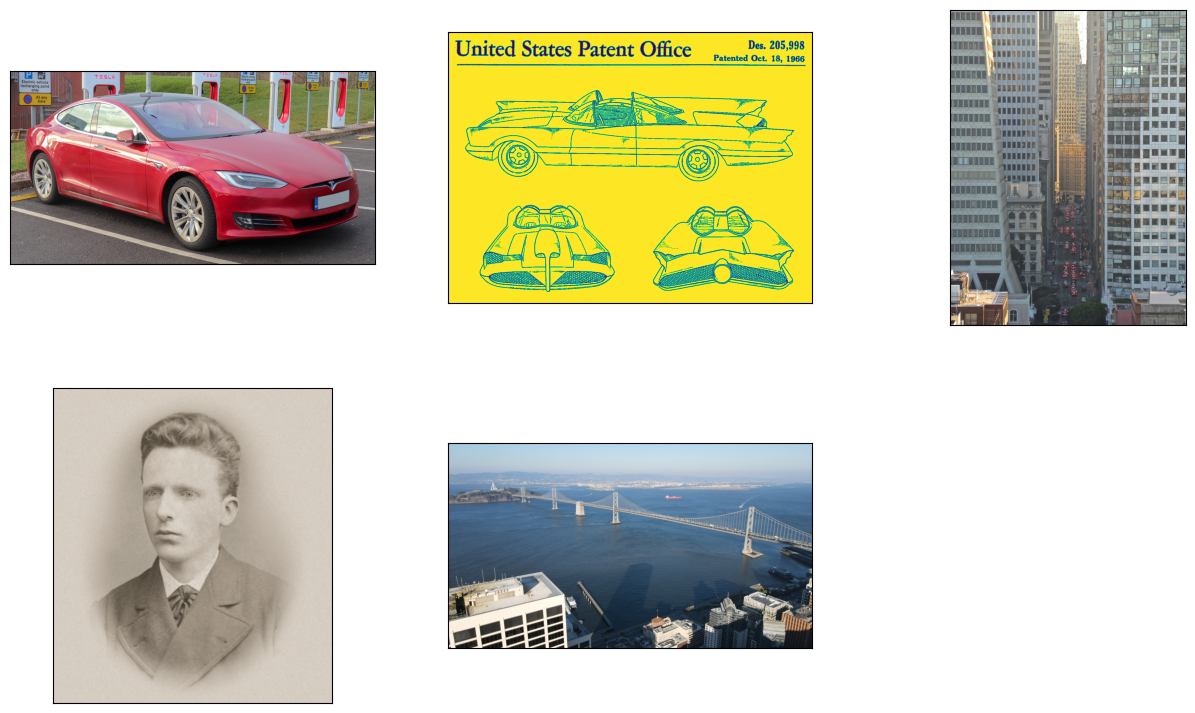

In [ ]:
test_query = "which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(
    similarity_top_k={Modalities.TEXT.key: 3, Modalities.IMAGE.key: 5}
)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** ff85b136-08c8-465d-96f5-a554c65067d8<br>**Similarity:** 0.8461934674061043<br>**Text:** ==== Personality ====
Batman's primary character traits can be summarized as "wealth; physical prowess; deductive abilities and obsession". The details and tone of Batman comic books have varied ov...<br>

**Node ID:** 55f5b842-6fd0-4e45-aef2-27f74f670e82<br>**Similarity:** 0.8229623965891602<br>**Text:** Batman is a superhero appearing in American comic books published by DC Comics. The character was created by artist Bob Kane and writer Bill Finger, and debuted in the 27th issue of the comic book ...<br>

**Node ID:** cb4755db-088e-46af-92b2-3a4a3649d9fe<br>**Similarity:** 0.8218281955244808<br>**Text:** === Enemies ===

Batman faces a variety of foes ranging from common criminals to outlandish supervillains. Many of them mirror aspects of the Batman's character and development, often having tragic...<br>

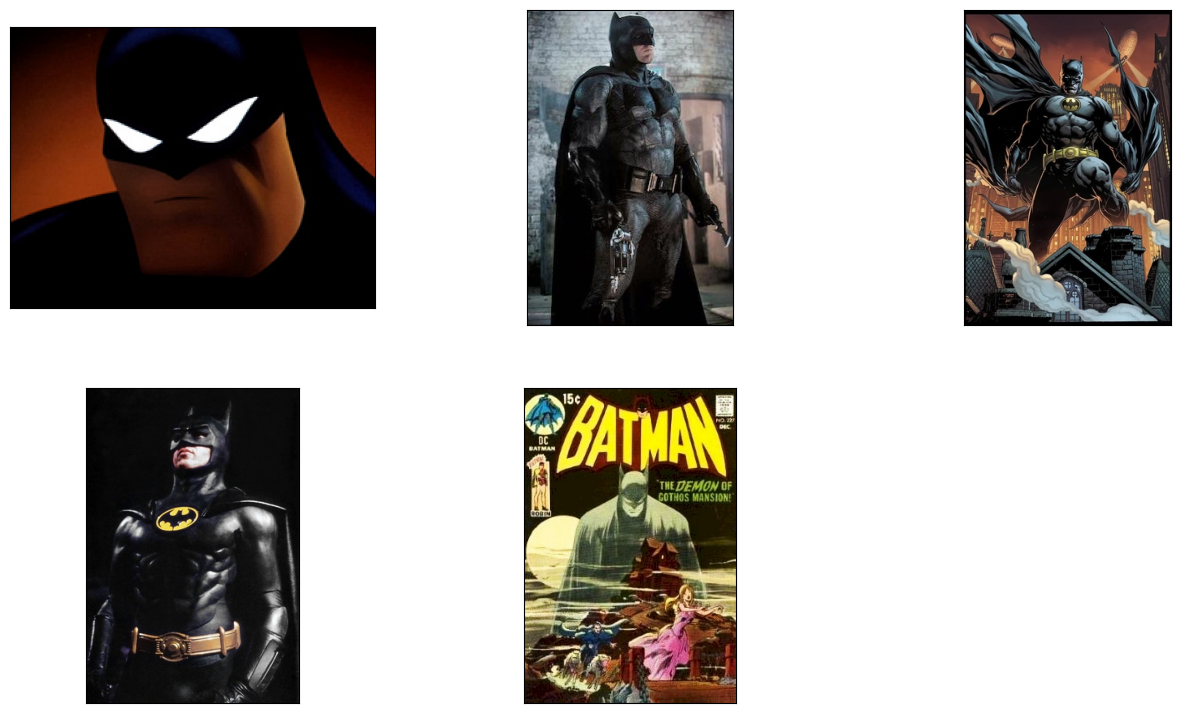

In [ ]:
test_query = "what is the main character in Batman"
# generate  retrieval results
retriever = index.as_retriever(
    similarity_top_k={Modalities.TEXT.key: 3, Modalities.IMAGE.key: 5}
)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)